<img src="https://www.bestdesigns.co/uploads/inspiration_images/4350/990__1511457498_404_walmart.png" alt="WALMART LOGO" />

# Walmart : predict weekly sales

## Company's Description 📇

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas. The company was founded by Sam Walton in 1962.

## Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

## Goals 🎯

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **linear regression model** (baseline)
- Part 3 : avoid overfitting by training a **regularized regression model**

In [1]:
#Import usual modules and librairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

In [2]:
#read sales data
data = pd.read_csv('datasets/Walmart_Store_sales.csv')

### Part 1 : EDA and data preprocessing

In [3]:
walmart_sales = data.copy()

#### 1. Statistics of Data set

Number of rows

In [4]:
print("Number of rows : {}".format(walmart_sales.shape[0]))
print()

Number of rows : 150



Display of dataset

In [5]:
display(walmart_sales.head())
print()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


Basics statistics:

In [6]:
data_desc = walmart_sales.describe(include='all')
display(data_desc)
print()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,07-01-2011,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


Missing  values 

Percentage of missing values: 


Store            0.000000
Holiday_Flag     8.000000
CPI              8.000000
Weekly_Sales     9.333333
Fuel_Price       9.333333
Unemployment    10.000000
Date            12.000000
Temperature     12.000000
dtype: float64

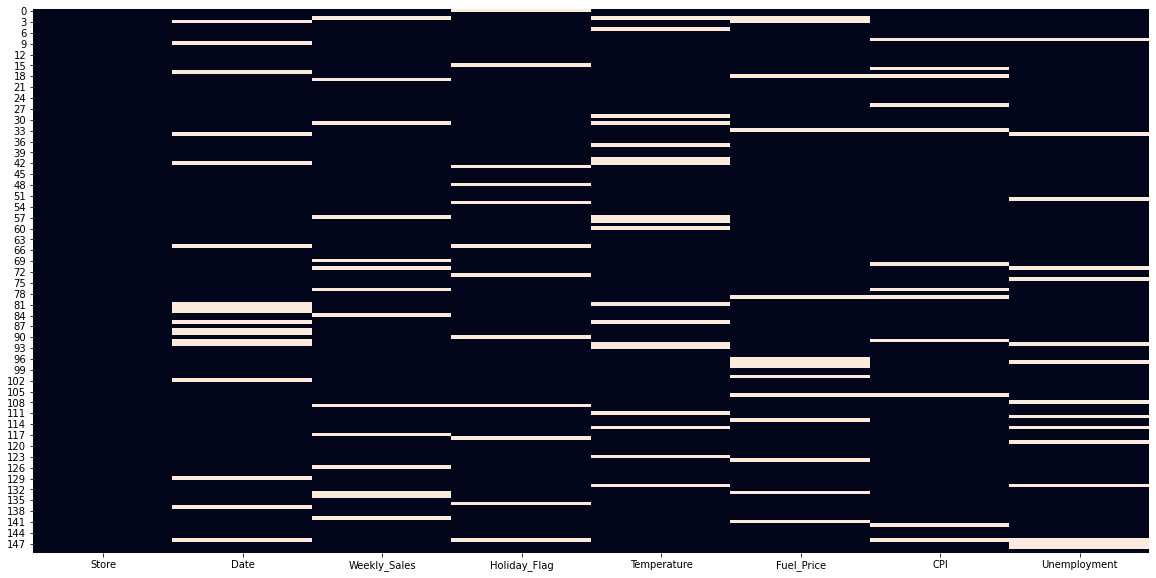

In [7]:
print("Percentage of missing values: ")
plt.figure(figsize=(20,10))
sns.heatmap(walmart_sales.isna(), cbar = False);
display((100*walmart_sales.isnull().sum()/walmart_sales.shape[0]).sort_values())
print()


Data set Columns

In [8]:
print("Data Set Columns: ")
display(walmart_sales.info())
print()

Data Set Columns: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


None

#### 2. Preprocessing  with pandas

In [9]:
target = ['Weekly_Sales']

**2.1 Drop lines where target values are missing**

In [10]:
#Drop lines with Weekly_Sales (target variable) missing
walmart_sales =  walmart_sales.dropna(axis = 0, subset=target)


In [11]:
walmart_sales.shape

(136, 8)

**2.2 Drop Date column**

In [12]:
walmart_sales = walmart_sales.drop('Date', axis = 1)

**2.3 Drop lines containing invalid values or outliers :**
In this project, will be considered as outliers all the numeric features that don't fall within the range : $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$. This concerns the columns : *Temperature*, *Fuel_price*, *CPI* and *Unemployment*

In [13]:
numerical_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for feature in numerical_features :
    print('Numerical features :', feature)
    to_keep = (walmart_sales[feature] > walmart_sales[feature].mean() - 3*walmart_sales[feature].std()) & (walmart_sales[feature] < walmart_sales[feature].mean() + 3*walmart_sales[feature].std())
    walmart_sales = walmart_sales.loc[to_keep,:]
    print('Data Leng :', walmart_sales.shape)

Numerical features : Temperature
Data Leng : (121, 7)
Numerical features : Fuel_Price
Data Leng : (109, 7)
Numerical features : CPI
Data Leng : (102, 7)
Numerical features : Unemployment
Data Leng : (90, 7)


In [14]:
walmart_sales.shape

(90, 7)

**2.4 Replace Nan in  Holiday_Flag by 0:**

In [15]:
 walmart_sales['Holiday_Flag'] = walmart_sales['Holiday_Flag'].fillna(0)

In [16]:
walmart_sales.shape


(90, 7)

In [17]:
walmart_sales.describe(include = 'all')

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,90.000000,9.000000e+01,90.000000,90.00000,90.000000,90.000000,90.000000
mean,9.900000,1.233865e+06,0.066667,61.06100,3.318444,179.524905,7.389733
std,6.204475,6.647250e+05,0.250841,17.74604,0.484399,39.554303,0.982729
min,1.000000,2.689290e+05,0.000000,18.79000,2.548000,126.128355,5.143000
25%,4.000000,5.617240e+05,0.000000,45.34250,2.814750,132.602339,6.642250
50%,9.000000,1.260826e+06,0.000000,61.45000,3.468000,197.166416,7.419000
75%,15.750000,1.807159e+06,0.000000,75.79250,3.737750,214.855374,8.099000
max,20.000000,2.771397e+06,1.000000,91.65000,4.170000,226.968844,9.342000


#### 2. Data Visualization with searborn

In [18]:
features = [col for col in walmart_sales.columns if col != 'Weekly_Sales']

**2.1 Continuous column distribution**

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


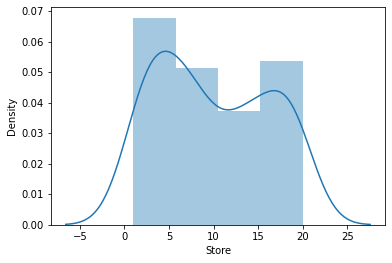

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


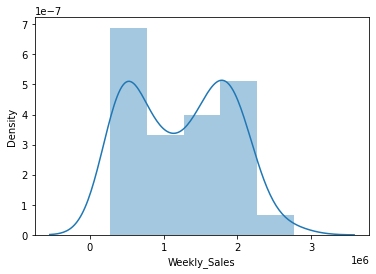

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


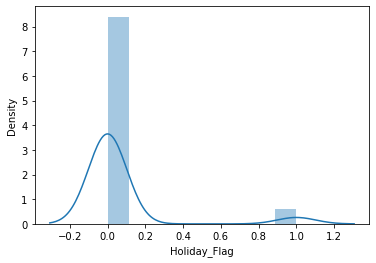

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


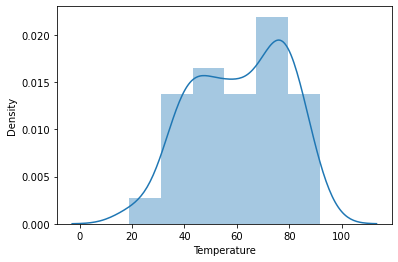

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


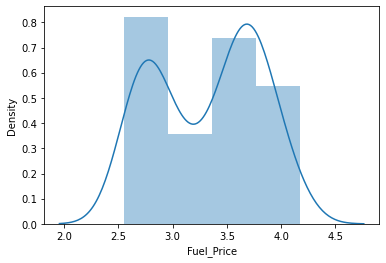

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


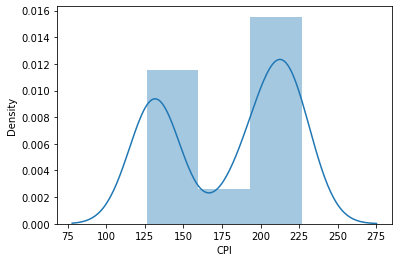

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


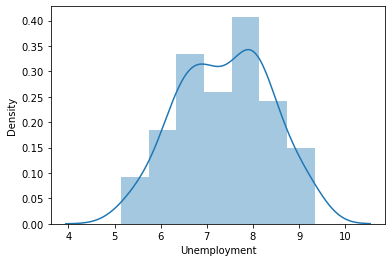

In [19]:
#walmart_sales.columns[]

for col in walmart_sales.select_dtypes('float') :
    plt.figure();
    sns.distplot(walmart_sales[col]);
    plt.show()

**2.1 RelationShip Features /  Target (Weekly_Sales)**

<Figure size 432x288 with 0 Axes>

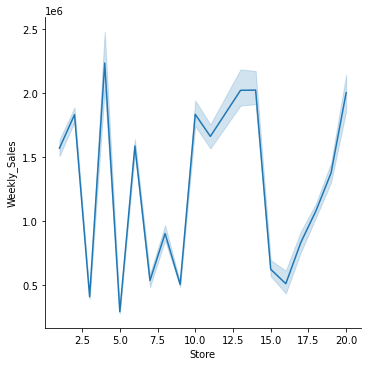

<Figure size 432x288 with 0 Axes>

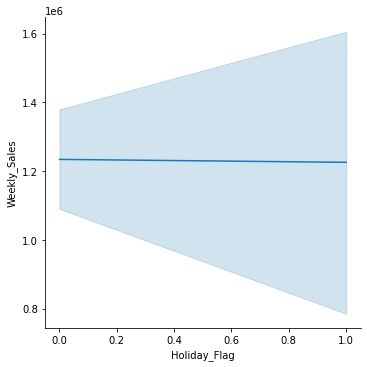

<Figure size 432x288 with 0 Axes>

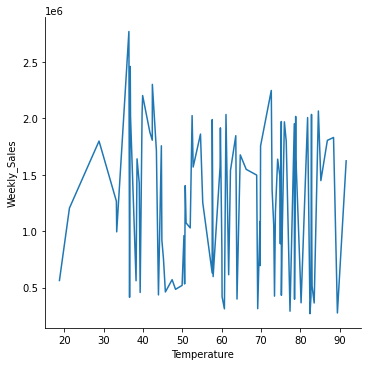

<Figure size 432x288 with 0 Axes>

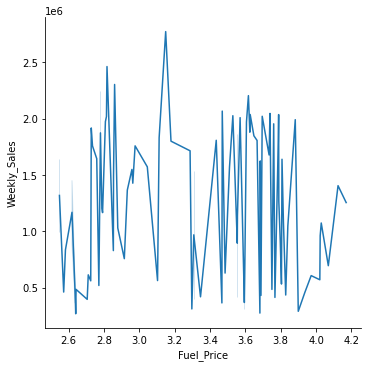

<Figure size 432x288 with 0 Axes>

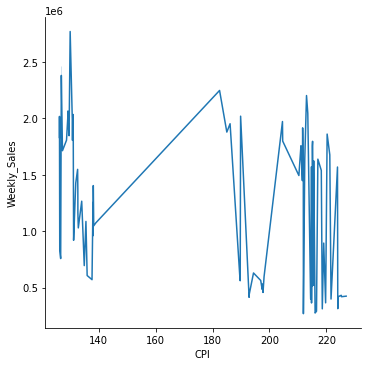

<Figure size 432x288 with 0 Axes>

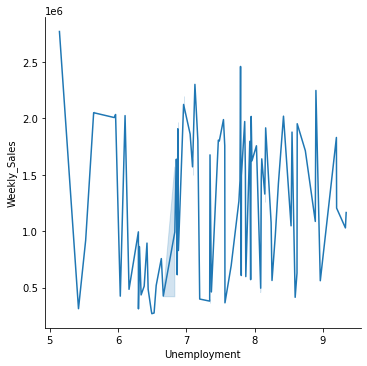

In [20]:
for col in features:
    plt.figure();
    sns.relplot(x=col, y="Weekly_Sales", data=walmart_sales, kind="line");
    plt.show()

**2.3 Correlation Matrix**

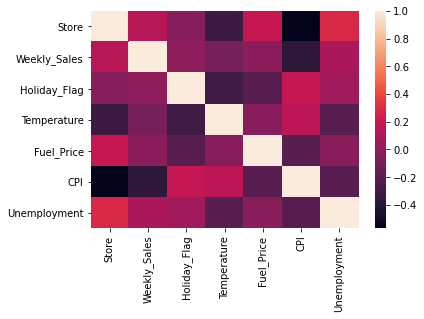

In [21]:
# Correlation matrix
corr_matrix = walmart_sales.corr()
sns.heatmap(corr_matrix);

In [22]:
corr_matrix

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000,0.140426,-0.038985,-0.322778,0.195787,-0.568758,0.285240
Weekly_Sales,0.140426,1.000000,-0.003242,-0.091299,-0.018320,-0.373895,0.094047
Holiday_Flag,-0.038985,-0.003242,1.000000,-0.300713,-0.203592,0.185079,0.056638
Temperature,-0.322778,-0.091299,-0.300713,1.000000,-0.035225,0.155212,-0.201256
Fuel_Price,0.195787,-0.018320,-0.203592,-0.035225,1.000000,-0.206546,-0.026149
CPI,-0.568758,-0.373895,0.185079,0.155212,-0.206546,1.000000,-0.205179
Unemployment,0.285240,0.094047,0.056638,-0.201256,-0.026149,-0.205179,1.000000


### Part 2 : Baseline model (linear regression)

In [23]:
X = walmart_sales.loc[:,features]
X

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,0.0,59.61,3.045,214.777523,6.858
1,13.0,0.0,42.38,3.435,128.616064,7.470
4,6.0,0.0,78.89,2.759,212.412888,7.092
6,15.0,0.0,69.80,4.069,134.855161,7.658
7,20.0,0.0,39.93,3.617,213.023623,6.961
...,...,...,...,...,...,...
139,7.0,0.0,50.60,3.804,197.588605,8.090
143,3.0,0.0,78.53,2.705,214.495838,7.343
144,3.0,0.0,73.44,3.594,226.968844,6.034
145,14.0,0.0,72.62,2.780,182.442420,8.899


In [24]:
y = walmart_sales.loc[:,target]
y

,Weekly_Sales
0,1572117.54
1,1807545.43
4,1644470.66
6,695396.19
7,2203523.20
...,...
139,532739.77
143,396968.80
144,424513.08
145,2248645.59


In [25]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [26]:
cat_features = ['Store', 'Holiday_Flag']

 #### 1. Preprocessings with scikit-learn

In [27]:
# Create pipeline for numeric features
numeric_features = [2,3,4,5] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

In [28]:
categorical_features = [0, 1] # Positions of categorical columns in X_train/X_test
encoder = OneHotEncoder(drop='first')
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


In [29]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [30]:
X_train = preprocessor.fit_transform(X_train)

In [31]:
X_test = preprocessor.transform(X_test)

 **2. Training model with a Linear Regression**

In [32]:
# Train model
print("Train model...")
regressor = LinearRegression()
egressor = regressor.fit(X_train, y_train)
print("...Done.")

Train model...
...Done.


 **3. Model predictions  and performances**

In [33]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = regressor.predict(X_train)
print("...Done.")
#print(y_train_pred)
print()

Predictions on training set...
...Done.



In [34]:
# Predictions on test set
print("Predictions on test set...")
y_test_pred = regressor.predict(X_test)
print("...Done.")
#print(y_test_pred)
print()

Predictions on test set...
...Done.



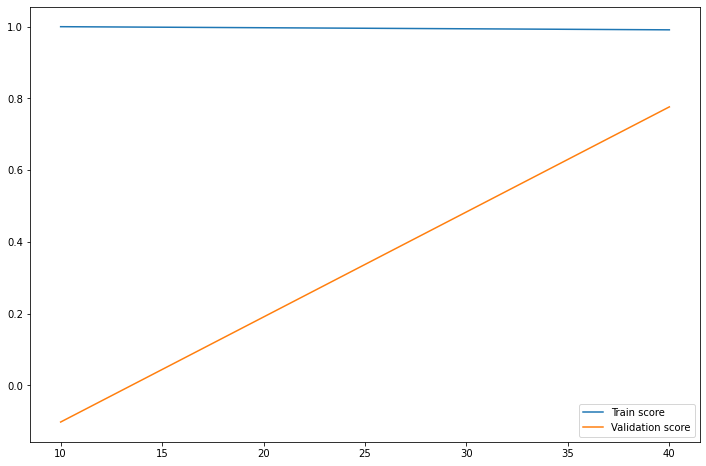

In [35]:
train_sizes, train_scores, valid_scores = learning_curve(regressor, X_train, y_train, 
                                                         train_sizes=[10, 40], cv=3)
plt.figure(figsize=(12,8))
plt.plot(train_sizes, train_scores.mean(axis=1), label = 'Train score')
plt.plot(train_sizes, valid_scores.mean(axis=1), label = 'Validation score')
plt.legend()

In [36]:
print("Linear R2 score on training set : ", regressor.score(X_train, y_train))
print("Linear R2 score on test set : ", regressor.score(X_test, y_test))

Linear R2 score on training set :  0.9820617245920473
Linear R2 score on test set :  0.9344198126038252


In [37]:
regressor.coef_

array([[-1.23104098e+03, -7.49677420e+04,  8.75655239e+05,
         4.57835651e+04,  2.84319143e+05, -1.23887594e+06,
         2.61975083e+06, -1.21008322e+06,  5.55093653e+04,
        -5.58675445e+05, -6.66213556e+05, -1.07797784e+06,
         2.17107371e+06,  1.44621554e+05,  2.46490564e+06,
         1.11309595e+06,  9.61587802e+05, -4.37963728e+05,
         1.29658565e+06,  1.33309443e+06,  1.67351001e+06,
         6.22065956e+05, -1.87867282e+04]])

### Part 3 : Fight overfitting

 **1. Using Ridge**

In [38]:
ridge_regressor = Ridge()

In [39]:
ridge_regressor.fit(X_train, y_train)

Ridge()

In [40]:
print("Ridge R2 Score on training set :  {}".format(ridge_regressor.score(X_train, y_train)))
print("Ridge R2 Score on test set : {}".format(ridge_regressor.score(X_test, y_test)))

Ridge R2 Score on training set :  0.9244828390188061
Ridge R2 Score on test set : 0.82142510322106


 **2. Using Lasso**

In [41]:
 lasso = Lasso()

In [42]:
lasso = lasso.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275015434875.24817, tolerance: 3009808860.5723906
  model = cd_fast.sparse_enet_coordinate_descent(


In [43]:
print("Lasso R2 score on training set : ", lasso.score(X_train, y_train))
print("Lasso R2 score on test set : ", lasso.score(X_test, y_test))

Lasso R2 score on training set :  0.9816949448903775
Lasso R2 score on test set :  0.9374693840645092


 **3. GridSearchCV**

In [44]:
# Perform grid search
print("Grid search with Ridge...")
regressor2 = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor2, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters for gridSearch Ridge : ", gridsearch.best_params_)
print("Best R2 score for gridSearch Ridge  : ", gridsearch.best_score_)

Grid search with Ridge...
...Done.
Best hyperparameters for gridSearch Ridge :  {'alpha': 0.0}
Best R2 score for gridSearch Ridge  :  0.8491982990450676


In [45]:
# Perform grid search
print("Grid search with Lasso...")
lasso2 = Lasso()
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0] # 0 corresponds to no regularization
}
gridsearch2 = GridSearchCV(lasso2, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch2.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters for gridSearch Lasso : ", gridsearch2.best_params_)
print("Best R2 score for gridSearch Lasso  : ", gridsearch2.best_score_)

Grid search with Lasso...


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166476414219.94153, tolerance: 2132244736.4906783
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

...Done.
Best hyperparameters for gridSearch Lasso :  {'alpha': 1.0}
Best R2 score for gridSearch Lasso  :  0.8821520558071366


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166564131695.70712, tolerance: 2132244736.4906783
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148308951253.67142, tolerance: 1940510871.4329298
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77985271702.58081, tolerance: 1907460795.372512
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: Converge